Dataset shape: (37, 133)

Heroes analyzed: 37

Heroes by Role:
Role
Damage     17
Tank       11
Support     9
Name: count, dtype: int64

CLUSTERING RESULTS

CLUSTER 0 (18 heroes)
Heroes: Genji, Cassidy, Hanzo, Reinhardt, Widowmaker, Soldier: 76, Tracer, Junkrat, Ashe, Reaper, Pharah, Doomfist, Mei, Bastion, Symmetra, Torbjorn, Sojourn, Echo

Average Stats:
  • Win Rate: 48.1%
  • KDA Ratio: 2.92
  • Eliminations/10min: 18.1
  • Damage/10min: 8186
  • Healing/10min: 1299
  • Deaths/10min: 7.9
  • Role Distribution: {'Damage': np.int64(16), 'Tank': np.int64(2)}

CLUSTER 1 (10 heroes)
Heroes: D.Va, Zarya, Roadhog, Sigma, Orisa, Winston, Sombra, Wrecking Ball, Ramattra, Junker Queen

Average Stats:
  • Win Rate: 45.7%
  • KDA Ratio: 4.62
  • Eliminations/10min: 18.7
  • Damage/10min: 8642
  • Healing/10min: nan
  • Deaths/10min: 6.2
  • Role Distribution: {'Tank': np.int64(9), 'Damage': np.int64(1)}

CLUSTER 2 (9 heroes)
Heroes: Ana, Mercy, Kiriko, Moira, Zenyatta, Lucio, Baptiste, Brigitt

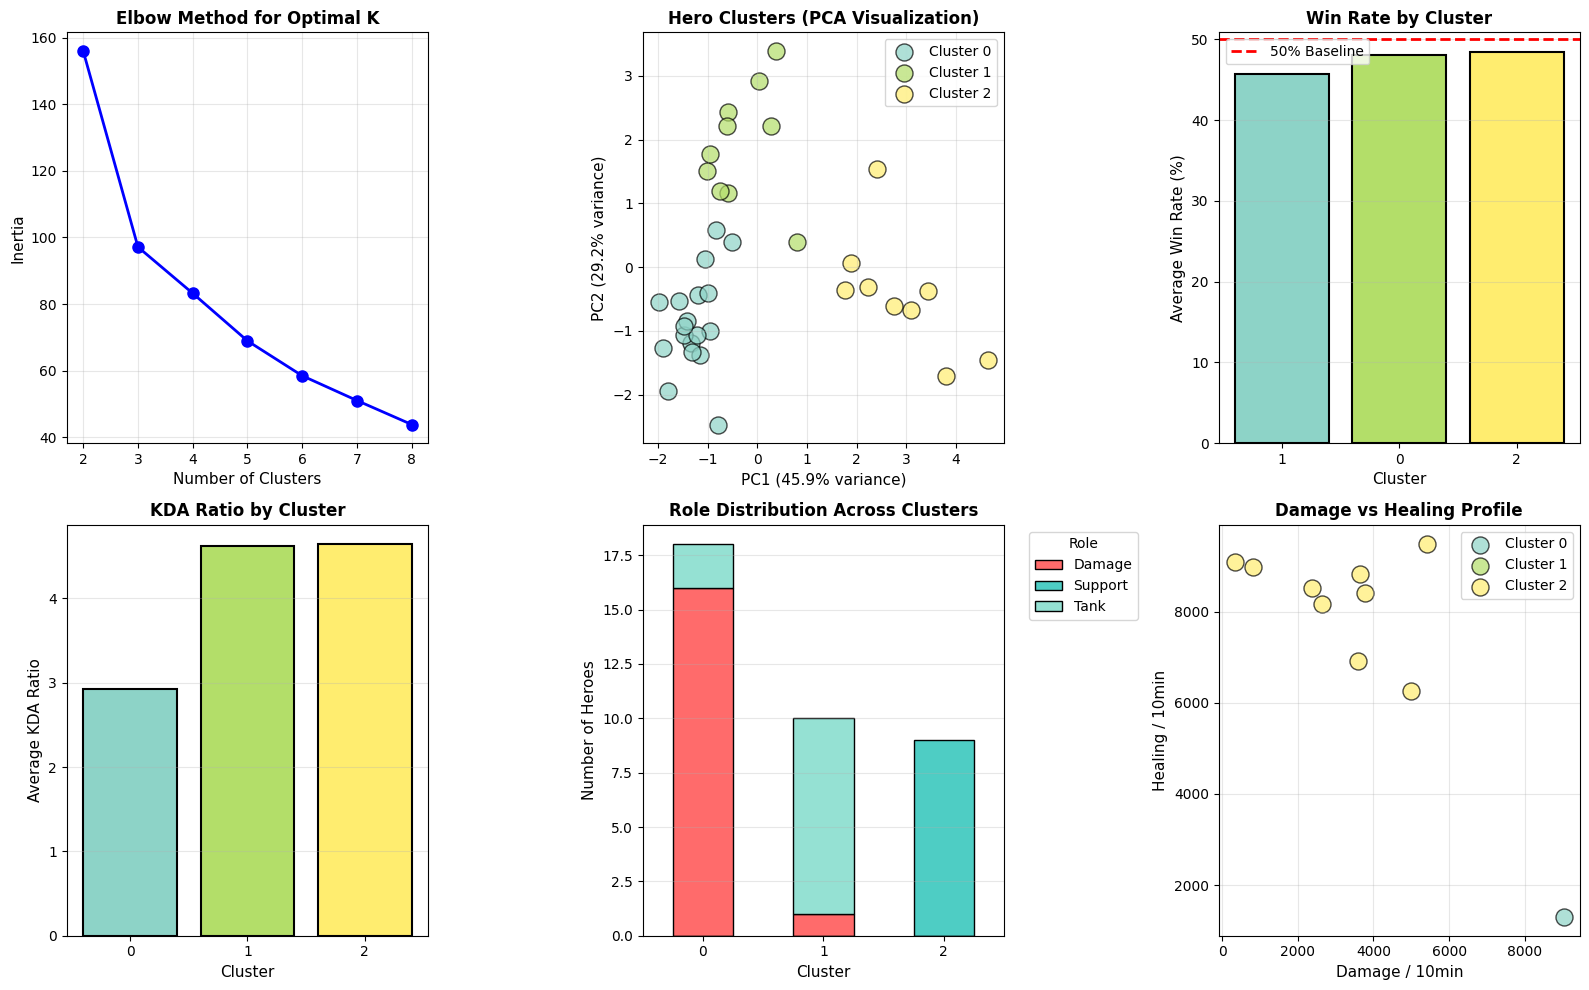


CLUSTER INTERPRETATION

Cluster 0: Damage

Cluster 1: Tank

Cluster 2: Support


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Read the CSV file
# df = pd.read_csv('ow2_quickplay_heroes_stats__2023-05-06.csv')
# df = pd.read_csv('ow2_season_01_FINAL_heroes_stats__2023-05-06.csv')
# df = pd.read_csv('ow2_season_02_FINAL_heroes_stats__2023-05-06.csv')
# df = pd.read_csv('ow2_season_03_FINAL_heroes_stats__2023-05-06.csv')
df = pd.read_csv('ow2_season_04_FINAL_heroes_stats__2023-06-27.csv')


# Filter to only "All" skill tier for overall hero patterns
df_all = df[df['Skill Tier'] == 'All'].copy()


print(f"Dataset shape: {df_all.shape}")
print(f"\nHeroes analyzed: {len(df_all)}")
print(f"\nHeroes by Role:")
print(df_all['Role'].value_counts())


# Select key performance metrics for clustering
features = [
    'KDA Ratio',
    'Win Rate, %',
    'Eliminations / 10min',
    'Deaths / 10min',
    'Damage / 10min',
    'Healing / 10min',
    'Objective Time / 10min'
]


# Prepare data - fill NaN values with 0 (for heroes without healing)
X = df_all[features].fillna(0)


# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Determine inertias for elbow plot (optional, to visualize cluster numbers)
inertias = []
K_range = range(2, 9)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)


# Perform clustering with 3 clusters - targeted to Overwatch roles: Tank, Support, DPS
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_all['Cluster'] = kmeans.fit_predict(X_scaled)


# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_all['PCA1'] = X_pca[:, 0]
df_all['PCA2'] = X_pca[:, 1]


print(f"\n{'='*60}")
print("CLUSTERING RESULTS")
print(f"{'='*60}")


# Analyze each cluster
for i in range(n_clusters):
    cluster_data = df_all[df_all['Cluster'] == i]
    print(f"\nCLUSTER {i} ({len(cluster_data)} heroes)")
    print(f"Heroes: {', '.join(cluster_data['Hero'].values)}")
    print(f"\nAverage Stats:")
    print(f"  • Win Rate: {cluster_data['Win Rate, %'].mean():.1f}%")
    print(f"  • KDA Ratio: {cluster_data['KDA Ratio'].mean():.2f}")
    print(f"  • Eliminations/10min: {cluster_data['Eliminations / 10min'].mean():.1f}")
    print(f"  • Damage/10min: {cluster_data['Damage / 10min'].mean():.0f}")
    print(f"  • Healing/10min: {cluster_data['Healing / 10min'].mean():.0f}")
    print(f"  • Deaths/10min: {cluster_data['Deaths / 10min'].mean():.1f}")
    print(f"  • Role Distribution: {dict(cluster_data['Role'].value_counts())}")


# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))


# 1. Elbow plot
plt.subplot(2, 3, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters', fontsize=11)
plt.ylabel('Inertia', fontsize=11)
plt.title('Elbow Method for Optimal K', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)


# 2. PCA Scatter plot
plt.subplot(2, 3, 2)
colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
for i in range(n_clusters):
    cluster_data = df_all[df_all['Cluster'] == i]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                c=[colors[i]], label=f'Cluster {i}', 
                s=150, alpha=0.7, edgecolors='black', linewidth=1, marker='o')


plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
plt.title('Hero Clusters (PCA Visualization)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)


# 3. Win Rate by Cluster
plt.subplot(2, 3, 3)
cluster_winrates = df_all.groupby('Cluster')['Win Rate, %'].mean().sort_values()
bars = plt.bar(cluster_winrates.index.astype(str), cluster_winrates.values, 
               color=colors, edgecolor='black', linewidth=1.5)
plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% Baseline')
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Average Win Rate (%)', fontsize=11)
plt.title('Win Rate by Cluster', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')


# 4. KDA Ratio comparison
plt.subplot(2, 3, 4)
cluster_kda = df_all.groupby('Cluster')['KDA Ratio'].mean().sort_values()
plt.bar(cluster_kda.index.astype(str), cluster_kda.values, 
        color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Average KDA Ratio', fontsize=11)
plt.title('KDA Ratio by Cluster', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')


# 5. Role distribution in clusters
plt.subplot(2, 3, 5)
role_cluster = pd.crosstab(df_all['Cluster'], df_all['Role'])
role_cluster.plot(kind='bar', stacked=True, ax=plt.gca(), 
                 color=['#FF6B6B', '#4ECDC4', '#95E1D3'], 
                 edgecolor='black', linewidth=1)
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Number of Heroes', fontsize=11)
plt.title('Role Distribution Across Clusters', fontsize=12, fontweight='bold')
plt.legend(title='Role', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')


# 6. Damage vs Healing scatter
plt.subplot(2, 3, 6)
for i in range(n_clusters):
    cluster_data = df_all[df_all['Cluster'] == i]
    plt.scatter(cluster_data['Damage / 10min'], 
                cluster_data['Healing / 10min'],
                c=[colors[i]], label=f'Cluster {i}',
                s=150, alpha=0.7, edgecolors='black', linewidth=1, marker='o')


plt.xlabel('Damage / 10min', fontsize=11)
plt.ylabel('Healing / 10min', fontsize=11)
plt.title('Damage vs Healing Profile', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


# Print cluster interpretation with focus on roles Tank, Support, DPS
print(f"\n{'='*60}")
print("CLUSTER INTERPRETATION")
print(f"{'='*60}")


for i in range(n_clusters):
    cluster_data = df_all[df_all['Cluster'] == i]
    avg_damage = cluster_data['Damage / 10min'].mean()
    avg_healing = cluster_data['Healing / 10min'].mean()
    avg_objective_time = cluster_data['Objective Time / 10min'].mean()
    
    print(f"\nCluster {i}:", end=" ")
    
    # Based on domain knowledge about common role characteristics
    if avg_healing > 4000:
        print("Support")
    elif avg_damage > 7000 and avg_healing < 2000:
        print("Damage")
    elif avg_objective_time > 70:
        print("Tank")
    else:
        print("Role categorization error.")
